In [1]:
!pip freeze | grep -E "qiskit|mapomatic"

mapomatic==0.13.0
qiskit==1.3.1
qiskit-addon-cutting==0.9.0
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2
qiskit-nature==0.7.2


In [8]:
from qiskit_ibm_runtime.fake_provider.backends import FakeKolkataV2
from qiskit.circuit.random import random_clifford_circuit
from qiskit.result import sampled_expectation_value
from qiskit import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import AerSimulator

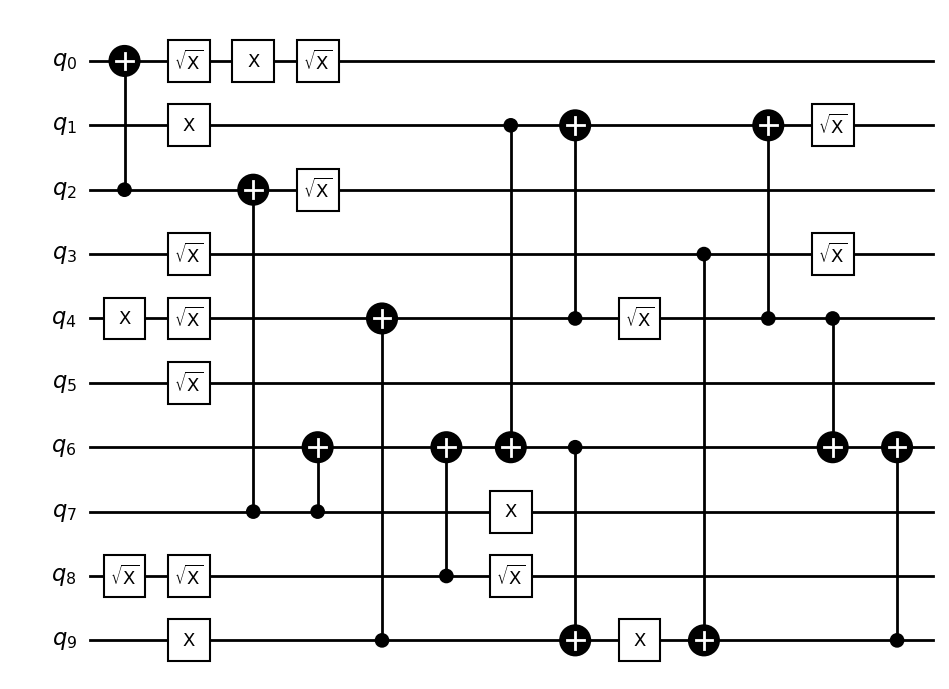

In [ ]:
num_gates, num_qubits = 30, 10
qc = random_clifford_circuit(
    num_qubits=num_qubits, num_gates=num_gates, gates=["x", "sx", "cx"], seed=42
)

qc.draw("mpl", fold=-1, style="bw")

In [4]:
observable = []

for idx in range(num_qubits):
    obs = "I" * idx + "Z" + "I" * (num_qubits - idx - 1)
    observable.append(obs)

observable = SparsePauliOp(observable)
observable

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])

In [6]:
pm = generate_preset_pass_manager(
    optimization_level=3, basis_gates=["x", "sx", "rz", "cx"]
)
shots = 4000

In [7]:
qc_copy = qc.copy()
qc_copy.measure_all()

isa_qc_copy = pm.run(qc_copy)

counts_ideal = AerSimulator().run(isa_qc_copy, shots=shots).result().get_counts()
ideal_expval = sampled_expectation_value(counts_ideal, observable)
ideal_expval

-0.026499999999999968

In [9]:
sampler = SamplerV2(mode=FakeKolkataV2())
sampler.options.default_shots = shots

In [11]:
pm = generate_preset_pass_manager(optimization_level=3, backend=FakeKolkataV2())
isa_qc = pm.run(qc_copy)

In [13]:
job = sampler.run([isa_qc])
result = job.result()[0]
uncut_counts = result.data.meas.get_counts()
uncut_expval = sampled_expectation_value(uncut_counts, observable)
uncut_expval

0.10399999999999998

### With Cutting

In [34]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)
from qiskit_addon_cutting import (
    reconstruct_expectation_values,
    generate_cutting_experiments,
    expand_observables,
    partition_problem,
    cut_wires,
)
from numpy import prod, inf, dot

In [18]:
optimization_settings = OptimizationParameters(seed=111)
device_constraints = DeviceConstraints(qubits_per_subcircuit=num_qubits // 2)

In [19]:
cut_circuit, metadata = find_cuts(qc, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling',
    f'overhead of {metadata["sampling_overhead"]}.\n',
    f'Lowest cost solution found: {metadata["minimum_reached"]}.',
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")

Found solution using 1 cuts with a sampling overhead of 16.0.
 Lowest cost solution found: True.
Wire Cut at circuit instruction index 12


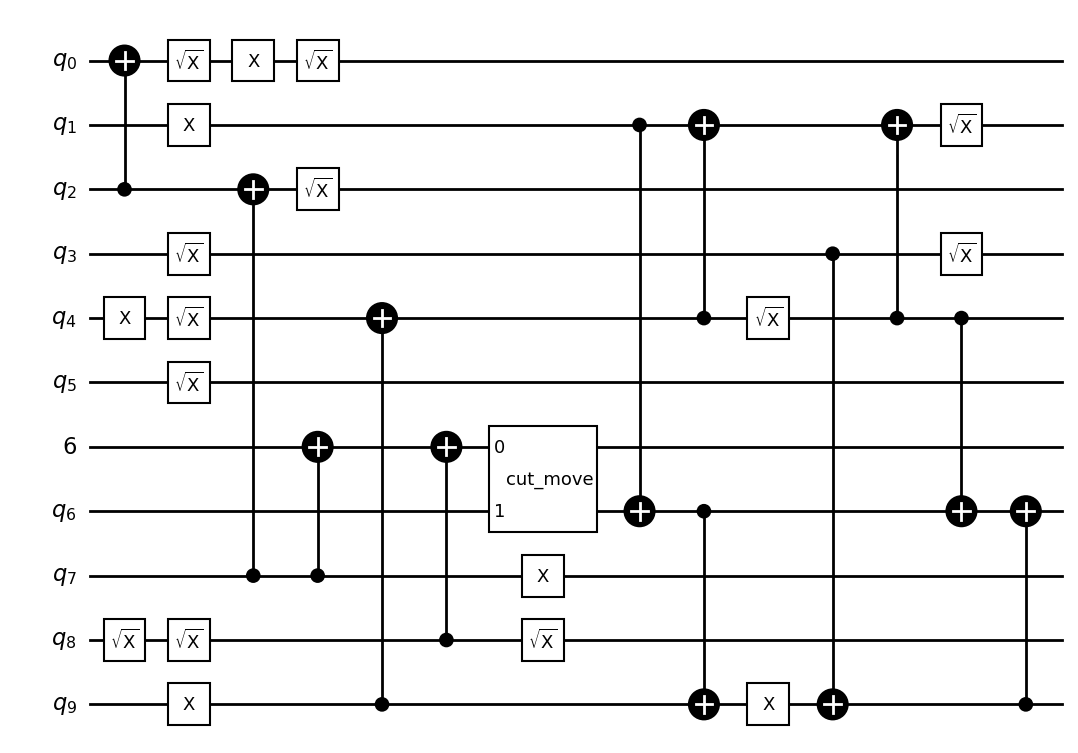

In [ ]:
qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, qc, qc_w_ancilla)
qc_w_ancilla.draw("mpl", style="bw", fold=-1)

In [26]:
partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

print(
    f"Sampling overhead: {prod([basis.overhead for basis in partitioned_problem.bases])}"
)
print(subobservables)
len(subcircuits)

Sampling overhead: 16.0
{0: PauliList(['IIIII', 'ZIIII', 'IZIII', 'IIIII', 'IIIII', 'IIIII', 'IIIII',
           'IIIZI', 'IIIII', 'IIIIZ']), 1: PauliList(['ZIIII', 'IIIII', 'IIIII', 'IZIII', 'IIIII', 'IIZII', 'IIIZI',
           'IIIII', 'IIIIZ', 'IIIII']), 2: PauliList(['I', 'I', 'I', 'I', 'Z', 'I', 'I', 'I', 'I', 'I'])}


3

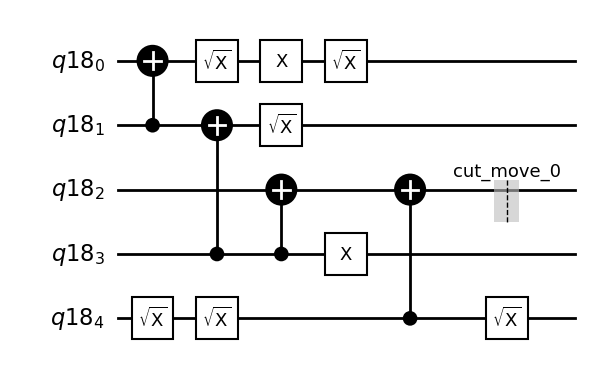

In [24]:
subcircuits[0].draw("mpl", style="bw", fold=-1)

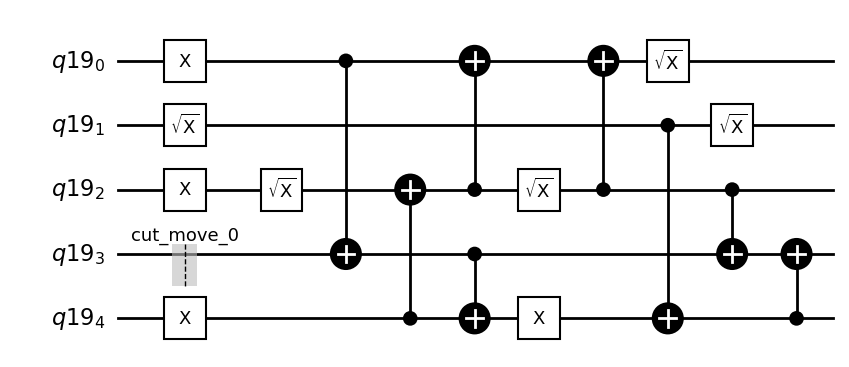

In [25]:
subcircuits[1].draw("mpl", style="bw", fold=-1)

In [30]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=inf
)

print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

16 total subexperiments to run on backend.


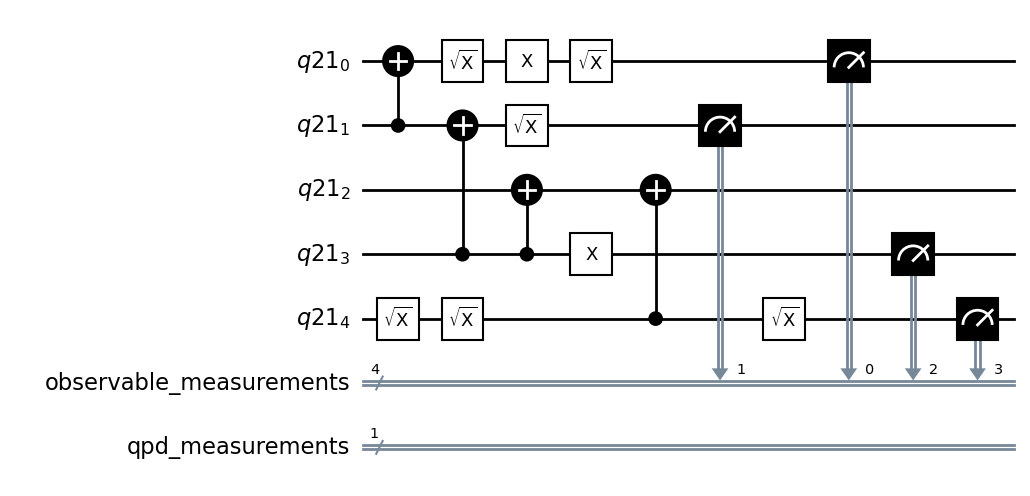

In [31]:
subexperiments[0][0].draw("mpl", style="bw", fold=-1)

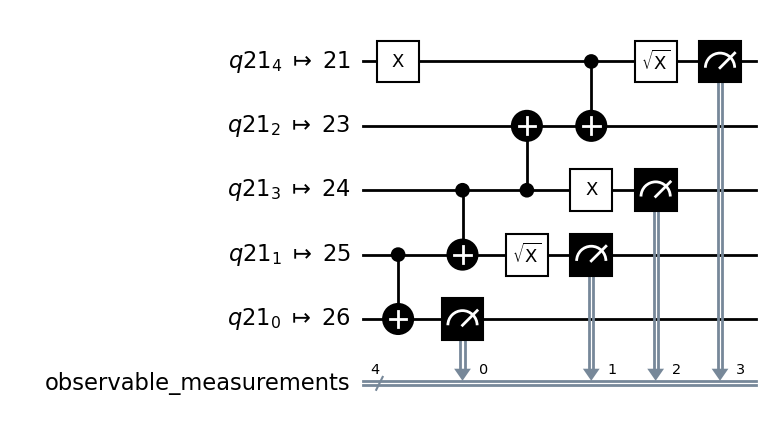

In [33]:
isa_subexperiments = {}

for key, circs in subexperiments.items():
    isa_subexperiments[key] = pm.run(circs)

isa_subexperiments[0][0].draw("mpl", style="bw", fold=-1, idle_wires=False)

In [35]:
jobs = {
    label: sampler.run(subsystem_subexpts)
    for label, subsystem_subexpts in isa_subexperiments.items()
}
results = {label: job.result() for label, job in jobs.items()}


reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = dot(reconstructed_expval_terms, observable.coeffs).real
reconstructed_expval

np.float64(0.024930624999997278)